In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def c_generate(x_range):
    bin=len(x_range)
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=abs(x_range[i]-x_range[j])
    return C

def normialise(tem_dist):
    return [tem_dist[i]/sum(tem_dist) for i in range(len(tem_dist))]

# def bisection(fun, a, b, stepmax, tol):
#     if fun(a)==0: return a
#     if fun(b)==0: return b
#     if sign(fun(a)) * sign(fun(b)) > 0: return print("bad section")
#     for step in range(1, stepmax+1):
#         c = (a + b) / 2
#         if sign(fun(c)) == 0: return c
#         if abs((b - a)/2) < tol: return (b + a) / 2
#         if sign(fun(c)) * sign(fun(a)) < 0:
#             b = c
#         else:
#             a = c
#     return (a + b) / 2  

def assess(bin,f,g,C,V,output):
    output=output.A1.reshape((bin,bin))
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f)))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g)))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+0.1**3))))
    print('tr violation:',sum(abs(output.T@V)))
    print('============================================')

def plots(x_range,g,f,output):
    fig = plt.figure(figsize=(3,3))
    gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4),left=0.1,right=0.9,bottom=0.1, top=0.9,wspace=0,hspace=0)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax.pcolormesh(x_range, x_range, output, cmap='Blues')
    ax.set_xlabel(r'supp($X$)',fontsize=10)
    ax.set_ylabel(r'supp($\tilde{X}$)',fontsize=10)#
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) 
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    #ax_histx.set_title(r'$Pr[x]$',rotation='horizontal')
    #ax_histy.set_title(r'$Pr[\tilde{x}]$')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histx.plot(x_range,g,color='tab:blue')
    ax_histy.plot(f,x_range,color='tab:green') 
    return fig

def tmp_generator(gamma_dict,num,q_dict,q_num,L):
    bin=gamma_dict[0].shape[0]
    if q_num<=0:
        q=np.matrix(np.ones((bin,bin)))
    else:
        q=q_dict[q_num]
    tmp_gamma=np.zeros((bin,bin))
    tmp_q=np.zeros((bin,bin))
    for i in range(bin):
        for j in range(bin):
            tmp_gamma[i,j]=q.item(i,j)*gamma_dict[num-1].item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
            tmp_q[i,j]=q.item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
    return np.matrix(tmp_gamma),np.matrix(tmp_q)  

def newton(fun,dfun,a, stepmax, tol):
    if abs(fun(a))<=tol: return a
    for step in range(1, stepmax+1):
        b=a-fun(a)/dfun(a)
        if abs(fun(b))<=tol:
            return b
        else:
            a = b
    return b 

# simplist
def baseline(C,e,px,ptx,V,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    #I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    gamma_classic=dict()
    gamma_classic[0]=np.matrix(xi+1.0e-9)
    for repeat in range(K):
        gamma_classic[1+2*repeat]=np.matrix(np.diag((px/(gamma_classic[2*repeat] @ bbm1)).A1))@gamma_classic[2*repeat] #np.diag(dist['x']/sum(gamma_classic.T))@gamma_classic
        gamma_classic[2+2*repeat]=gamma_classic[1+2*repeat]@np.matrix(np.diag((ptx/(gamma_classic[1+2*repeat].T @ bbm1)).A1))

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_classic[2*K])
    return gamma_classic[2*K]

# our method | total repair
def total_repair(C,e,px,ptx,V,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    gamma_dict=dict()
    gamma_dict[0]=np.matrix(xi+1.0e-9)
    gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
    gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
    # step 3
    J=np.where(~((gamma_dict[2].T @ V).A1 ==0))[0].tolist()
    nu=np.zeros(bin)
    gamma_dict[3]=np.copy(gamma_dict[2])
    for j in J:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
        dfun = lambda z: sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 50,tol = 1.0e-4) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(nu*V.item(i))*gamma_dict[2].item(i,j)
    gamma_dict[3]=np.matrix(gamma_dict[3])

    #=========================
    L=3
    q_dict=dict()

    for loop in range(1,K):
        tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
        gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

        tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
        gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

        # step 3
        tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
        J=np.where(~((abs(np.matrix(tmp).T @ V).A1)<=1.0e-4))[0].tolist()
        gamma_dict[loop*L+3]=np.copy(tmp)
        for j in J:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
            dfun = lambda z: sum(tmp.item(i,j)*(V.item(i))**2*np.exp(z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 50,tol = 1.0e-4) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(nu*V.item(i))*tmp.item(i,j)
        gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])
        
        if sum(abs(gamma_dict[loop*L+3].T@V))<=1.0e-4:  #'tr violation:'
            break;

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[L*(loop+1)])
    return gamma_dict[L*(loop+1)]

# our method | partial repair
def partial_repair(C,e,px,ptx,V,theta_scale,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    theta=bbm1*theta_scale
    gamma_dict=dict()
    gamma_dict[0]=np.matrix(xi+1.0e-9)
    gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
    gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
    # step 3
    Jplus=np.where(~((gamma_dict[2].T @ V).A1 <=theta.A1))[0].tolist()
    Jminus=np.where(~((gamma_dict[2].T @ V).A1>=-theta.A1))[0].tolist()
    gamma_dict[3]=np.copy(gamma_dict[2])
    for j in Jplus:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)-theta.item(j)
        dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 50,tol = 1.0e-4) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(-nu*V.item(i))*gamma_dict[2].item(i,j)
    for j in Jminus:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
        dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 50,tol = 1.0e-4) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(-nu*V.item(i))*gamma_dict[2].item(i,j)
    gamma_dict[3]=np.matrix(gamma_dict[3])

    #=========================
    L=3
    q_dict=dict()
    for loop in range(1,K):
        tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
        gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

        tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
        gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

        # step 3
        tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
        Jplus=np.where(~((np.matrix(tmp).T @ V).A1 <=theta.A1))[0].tolist()
        Jminus=np.where(~((np.matrix(tmp).T @ V).A1>=-theta.A1))[0].tolist()
        gamma_dict[loop*L+3]=np.copy(tmp)
        for j in Jplus:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)-theta.item(j)
            dfun = lambda z: -sum(tmp.item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 50,tol = 1.0e-4) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
        for j in Jminus:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
            dfun = lambda z: -sum(tmp.item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 50,tol = 1.0e-4) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
        gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])
        if sum(abs(gamma_dict[loop*L+3].T@V))<1.0e-4:  #'tr violation:'
            break;
    
    assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[L*(loop+1)])
    return gamma_dict[L*(loop+1)]
    
def Gaussian_pdf(x,name,para):
    mu=para[name+'_mean']
    sigma=para[name+'_sd']
    return math.exp(((x-mu)/sigma)**2*(-1/2))/(sigma*math.sqrt(2*math.pi))  

def samples_groupby(data):
    # for better complexity
    df=data.groupby(by=['X','S'],as_index=False).sum()
    return df[df['W']!=0]

def data_generation(num,para):
    x_range=np.arange(para['horizen'][0],para['horizen'][1],para['width'])
    df=pd.DataFrame(columns=['X', 'S'])
    for ignore in range(num):
        if np.random.random()<para['s_0']:
            X=np.floor(np.random.normal(para['X_0_mean'],para['X_0_sd'],size=[1]))
            if X>max(x_range):
                X=max(x_range)
            if X<min(x_range):
                X=min(x_range)
            sample=[X,'0']
        else:
            X=np.floor(np.random.normal(para['X_1_mean'],para['X_1_sd'],size=[1]))
            if X>max(x_range):
                X=max(x_range)
            if X<min(x_range):
                X=min(x_range)
            sample=[X,'1']
        df=pd.concat([df, pd.DataFrame(sample,index=['X','S']).T], ignore_index=True)
    df['W']=1
    df['X']=df['X'].astype('int64')  
    return df

def projection(df,coupling_matrix,x_range):
    bin=len(x_range)
    coupling=coupling_matrix.A1.reshape((bin,bin))
    df_t=pd.DataFrame(columns=['X','S','W'])
    loc_dict=dict(zip(x_range,[*range(bin)]))
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        loc=loc_dict[orig['X']] #np.where([x_range[b]==orig['X'] for b in range(bin)])[0][0]
        sub=pd.DataFrame(columns=['X','W'],index=x_range)
        sub['X']=x_range
        sub['W']=coupling[loc,:]/(sum(coupling[loc,:]))*orig['W']
        sub['S']=orig['S']
        df_t=pd.concat([df_t, samples_groupby(sub)], ignore_index=True)
    return df_t

def rdata_analysis(rdata,x_range):
    #bin=len(x_range)
    rdist=dict()
    rdist['x']=empirical_distribution(rdata,x_range)
    rdist['x_0']=empirical_distribution(rdata[rdata['S']=='0'],x_range)
    rdist['x_1']=empirical_distribution(rdata[rdata['S']=='1'],x_range)
    return rdist

def empirical_distribution(sub,x_range):
    bin=len(x_range)
    distrition=np.zeros(bin)
    for i in range(bin):
        subset=sub[sub['X']==x_range[i]] #bin_value=x_range[i] #sub[(sub['X']>=bin_value)&(sub['X']<bin_value+width)]
        if subset.shape[0]>0:
            distrition[i]=sum(subset['W'])
    if sum(distrition)>0:
        return distrition/sum(distrition)
    else:
        return distrition

In [4]:
# definition of parameters
np.random.seed(seed=123)

para = dict()
para['X_0_mean']=-10
para['X_0_sd']=6
para['X_1_mean']=1
para['X_1_sd']=3
para['X_t_mean']=-5
para['X_t_sd']=5
para['s_0']=0.7
para['s_1']=0.3
para['horizen']=[-30,10]
para['width']=1
x_range=np.arange(para['horizen'][0],para['horizen'][1],para['width'])
bin=len(x_range)

# data generation
M=10000
data=samples_groupby(data_generation(M,para))
dist=rdata_analysis(data,x_range)
dist['s']=[sum(data[data['S']=='0']['W'])/M,sum(data[data['S']=='1']['W'])/M]
dist['t_x']=normialise([Gaussian_pdf(x,'X_t',para)*para['width'] for x in x_range]) #because the sum is not 1
dist['v']=(dist['x_0']-dist['x_1'])/dist['x']

e=0.01
C=c_generate(x_range)
px=np.matrix(dist['x']).T
ptx=np.matrix(dist['t_x']).T
V=np.matrix(dist['v']).T
K=200

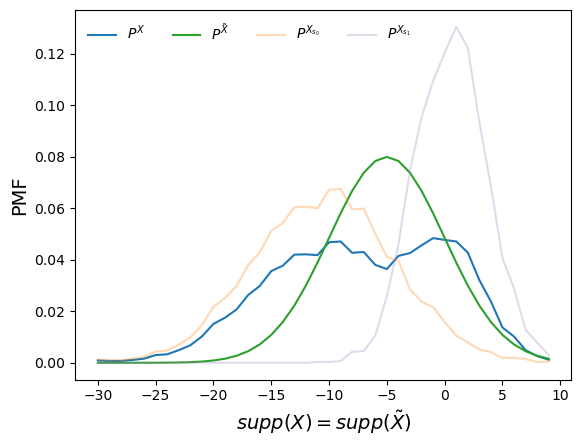

In [5]:
# make the overview plot
plt.plot(x_range,dist['x'],label=r'$P^{X}$',color='tab:blue')
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist['x_0'],label=r'$P^{X_{s_0}}$',alpha=0.3,color='tab:orange')
plt.plot(x_range,dist['x_1'],label=r'$P^{X_{s_1}}$',alpha=0.3,color='#9f86c0')
plt.ylabel('PMF',fontsize=14)
plt.xlabel(r'$supp(X)=supp(\tilde{X})$',fontsize=14)
plt.legend(ncol=4,frameon=False)
plt.savefig('C:/Users/zhouq/Downloads/SourceTarget_example.pdf',bbox_inches = 'tight')

In [6]:
# computation of couplings (just an example)
# baseline(C,e,px,ptx,V,K)
# total_repair(C,e,px,ptx,V,K)
# partial_repair(C,e,px,ptx,V,1.0e-3,K)

In [7]:
# computation of couplings and projection
rdata_base=projection(data,baseline(C,e,px,ptx,V,K),x_range)
rdata_part2=projection(data,partial_repair(C,e,px,ptx,V,1.0e-2,K),x_range)
rdata_part3=projection(data,partial_repair(C,e,px,ptx,V,1.0e-3,K),x_range)
rdata_total=projection(data,total_repair(C,e,px,ptx,V,K),x_range)

sum of violation of f: 0.000983239820289548
sum of violation of g: 1.7890574631696183e-16
total cost: 2.8184794115830916
entropy: 3.9924534958697198
tr violation: [[1.2388476]]
sum of violation of f: 0.00023795850995256566
sum of violation of g: 0.00022735214038950674
total cost: 5.216223217991852
entropy: 4.542474924135716
tr violation: [[0.26079181]]
sum of violation of f: 0.002831510825446605
sum of violation of g: 3.948823678875561e-05
total cost: 5.979486247366279
entropy: 4.635198182049518
tr violation: [[0.0314244]]
sum of violation of f: 0.0019484557504927398
sum of violation of g: 3.516958763222974e-06
total cost: 6.101079503099075
entropy: 4.649178609236541
tr violation: [[0.00068823]]


In [8]:
# computation of empirical distributions
dist_origin=rdata_analysis(data,x_range)
rdist_base=rdata_analysis(rdata_base,x_range)
rdist_part2=rdata_analysis(rdata_part2,x_range)
rdist_part3=rdata_analysis(rdata_part3,x_range)
rdist_total=rdata_analysis(rdata_total,x_range)

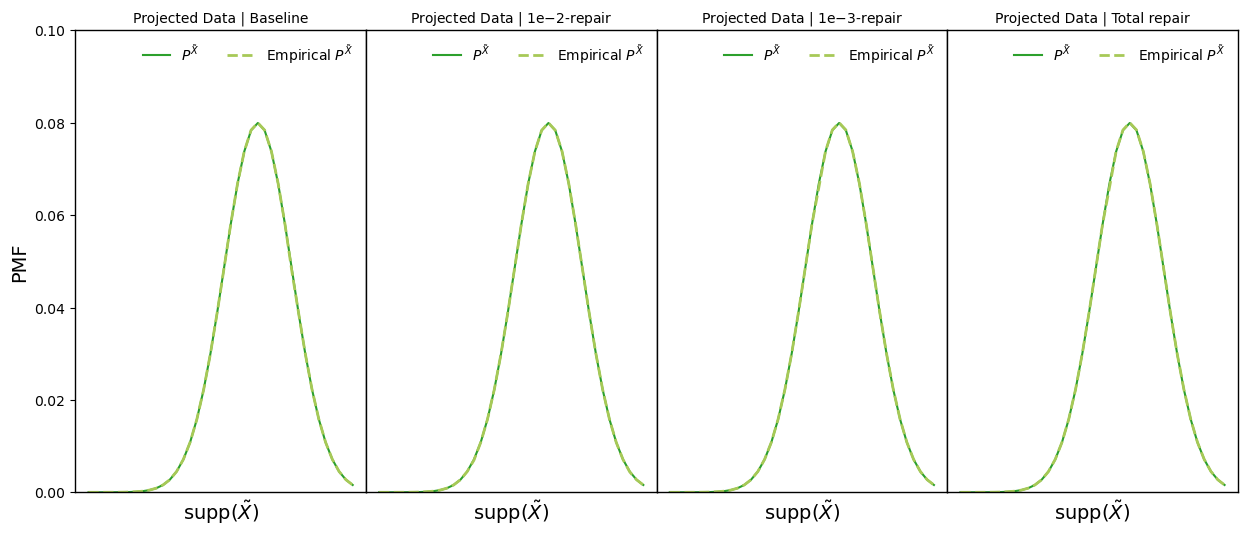

In [34]:
ymax=0.1
fig = plt.figure(figsize=(15,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,4),(0,0), rowspan=1, colspan=1)
dist_tmp=rdist_base
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.xticks([])
plt.ylabel('PMF',fontsize=14)
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Baseline',fontsize=10)
ax=plt.subplot2grid((1,4),(0,1), rowspan=1, colspan=1)
dist_tmp=rdist_part2
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-2}$-repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
ax=plt.subplot2grid((1,4),(0,2), rowspan=1, colspan=1)
dist_tmp=rdist_part3
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-3}$-repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
ax=plt.subplot2grid((1,4),(0,3), rowspan=1, colspan=1)
dist_tmp=rdist_total
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Total repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
plt.savefig('C:/Users/zhouq/Downloads/groupblind.pdf',bbox_inches = 'tight')

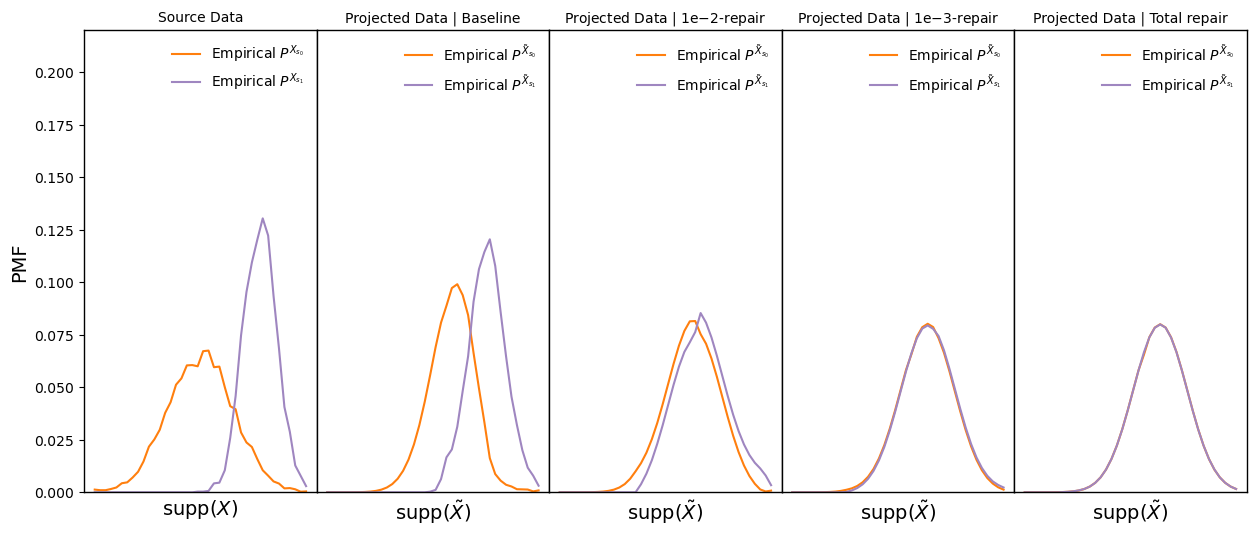

In [35]:
ymax=0.22
fig = plt.figure(figsize=(15,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,5),(0,0), rowspan=1, colspan=1)
dist_tmp=dist_origin
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{X_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{X_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.xticks([])
plt.xlabel(r'supp($X$)',fontsize=14)
plt.ylabel('PMF',fontsize=14)
plt.title('Source Data',fontsize=10)
ax=plt.subplot2grid((1,5),(0,1), rowspan=1, colspan=1)
dist_tmp=rdist_base
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Baseline',fontsize=10)
ax=plt.subplot2grid((1,5),(0,2), rowspan=1, colspan=1)
dist_tmp=rdist_part2
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-2}$-repair',fontsize=10)
ax=plt.subplot2grid((1,5),(0,3), rowspan=1, colspan=1)
dist_tmp=rdist_part3
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-3}$-repair',fontsize=10)
ax=plt.subplot2grid((1,5),(0,4), rowspan=1, colspan=1)
dist_tmp=rdist_total
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Total repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
plt.savefig('C:/Users/zhouq/Downloads/groupwise.pdf',bbox_inches = 'tight')

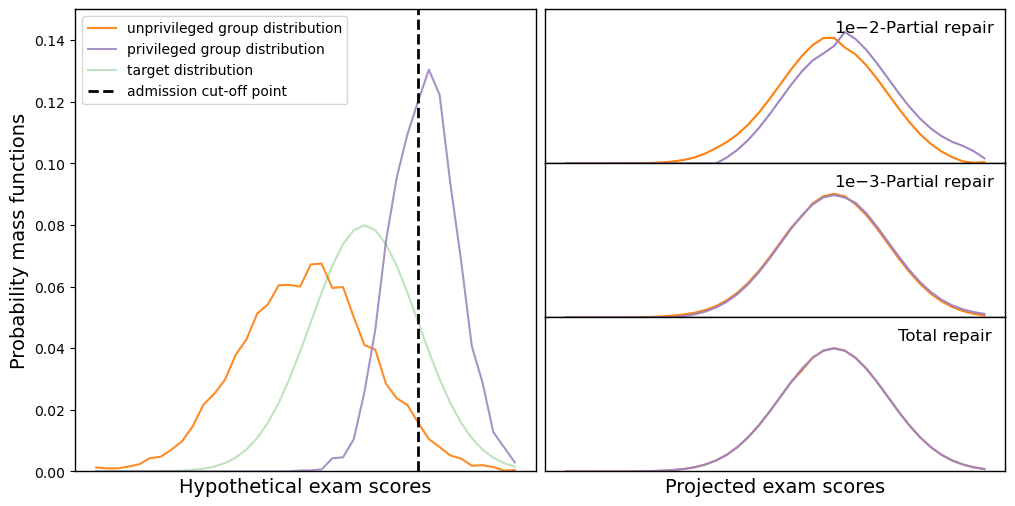

In [61]:
ymax=0.1
fig = plt.figure(figsize=(12,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((3,2),(0,0), rowspan=3, colspan=1)
plt.plot(x_range,dist['x_0'],label='unprivileged group distribution',alpha=0.9,color='tab:orange')
plt.plot(x_range,dist['x_1'],label='privileged group distribution',alpha=0.9,color='#9f86c0')
#plt.plot(x_range,dist['x'],label='group-blind distribution',color='tab:blue')
plt.plot(x_range,dist['t_x'],label='target distribution',alpha=0.3,color='tab:green')
plt.axvline(x=0, color='black', label='admission cut-off point',ls='--', lw=2)
plt.xticks([])
plt.ylim([0,0.15])
plt.ylabel('Probability mass functions',fontsize=14)
plt.xlabel('Hypothetical exam scores',fontsize=14)
plt.legend()
ax=plt.subplot2grid((3,2),(0,1), rowspan=1, colspan=1)
dist_tmp=rdist_part2
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.yticks([])
plt.xticks([])
plt.text(-5, 0.085, r'$1\mathrm{e}{-2}$-Partial repair', fontsize=12)
ax=plt.subplot2grid((3,2),(1,1), rowspan=1, colspan=1)
dist_tmp=rdist_part3
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.yticks([])
plt.xticks([])
plt.text(-5, 0.085, r'$1\mathrm{e}{-3}$-Partial repair', fontsize=12)
ax=plt.subplot2grid((3,2),(2,1), rowspan=1, colspan=1)
dist_tmp=rdist_total
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.yticks([])
plt.xticks([])
plt.xlabel('Projected exam scores',fontsize=14)
plt.text(1, 0.085, 'Total repair', fontsize=12)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.02,hspace=0.)
plt.savefig('C:/Users/zhouq/Downloads/motivation_example.pdf',bbox_inches = 'tight')

sum of violation of f: 0.000983239820289548
sum of violation of g: 1.7890574631696183e-16
total cost: 2.8184794115830916
entropy: 3.9924534958697198
tr violation: [[1.2388476]]


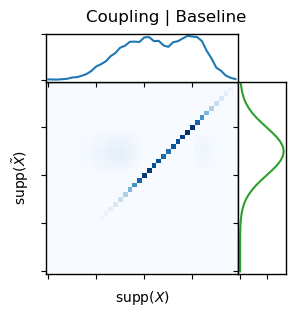

In [11]:
fig=plots(x_range,dist['x'],dist['t_x'],baseline(C,e,px,ptx,V,K).T.A1.reshape((bin,bin)))
fig.suptitle('Coupling | Baseline')
plt.savefig('C:/Users/zhouq/Downloads/coupling_base.pdf',bbox_inches = 'tight')

sum of violation of f: 0.00023795850995256566
sum of violation of g: 0.00022735214038950674
total cost: 5.216223217991852
entropy: 4.542474924135716
tr violation: [[0.26079181]]


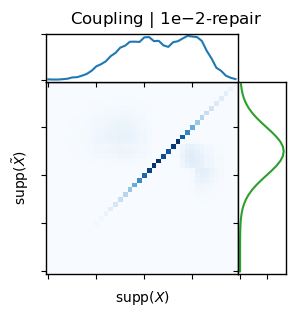

In [37]:
fig=plots(x_range,dist['x'],dist['t_x'],partial_repair(C,e,px,ptx,V,1.0e-2,K).T.A1.reshape((bin,bin)))
fig.suptitle(r'Coupling | $1\mathrm{e}{-2}$-repair')
plt.savefig('C:/Users/zhouq/Downloads/coupling_part2.pdf',bbox_inches = 'tight')

sum of violation of f: 0.002831510825446605
sum of violation of g: 3.948823678875561e-05
total cost: 5.979486247366279
entropy: 4.635198182049518
tr violation: [[0.0314244]]


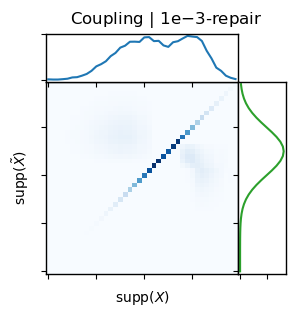

In [38]:
fig=plots(x_range,dist['x'],dist['t_x'],partial_repair(C,e,px,ptx,V,1.0e-3,K).T.A1.reshape((bin,bin)))
fig.suptitle(r'Coupling | $1\mathrm{e}{-3}$-repair')
plt.savefig('C:/Users/zhouq/Downloads/coupling_part3.pdf',bbox_inches = 'tight')

sum of violation of f: 0.0019484557504927398
sum of violation of g: 3.516958763222974e-06
total cost: 6.101079503099075
entropy: 4.649178609236541
tr violation: [[0.00068823]]


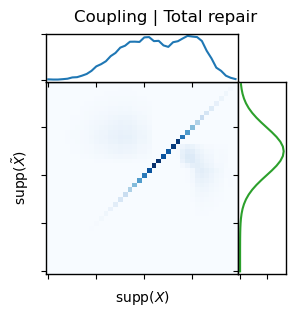

In [14]:
fig=plots(x_range,dist['x'],dist['t_x'],total_repair(C,e,px,ptx,V,K).T.A1.reshape((bin,bin)))
fig.suptitle('Coupling | Total repair')
plt.savefig('C:/Users/zhouq/Downloads/coupling_total.pdf',bbox_inches = 'tight')